In [1]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import keras
import librosa
import librosa.display

import numpy as np
import pandas as pd

import IPython.display as ipd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import gc

### Load "eval" dataset for the training phase

In [2]:
features = []
labels = []
features_p2 = []
labels_p2 = []

with open('/kaggle/input/dataset-asvspoof/eval_features.npz', 'rb') as f1:
    features = np.load(f1)
    features = features['a']

with open('/kaggle/input/dataset-asvspoof/eval_labels.npz', 'rb') as l1:
    labels = np.load(l1)
    labels = labels['a']
    
with open('/kaggle/input/dataset-asvspoof/eval_features_2.npz', 'rb') as f2:
    features_p2 = np.load(f2)
    features_p2 = features_p2['a']

with open('/kaggle/input/dataset-asvspoof/eval_labels_2.npz', 'rb') as l2:
    labels_p2 = np.load(l2)
    labels_p2 = labels_p2['a']

features_final = np.concatenate((features,features_p2))
labels_final = np.concatenate((labels,labels_p2))

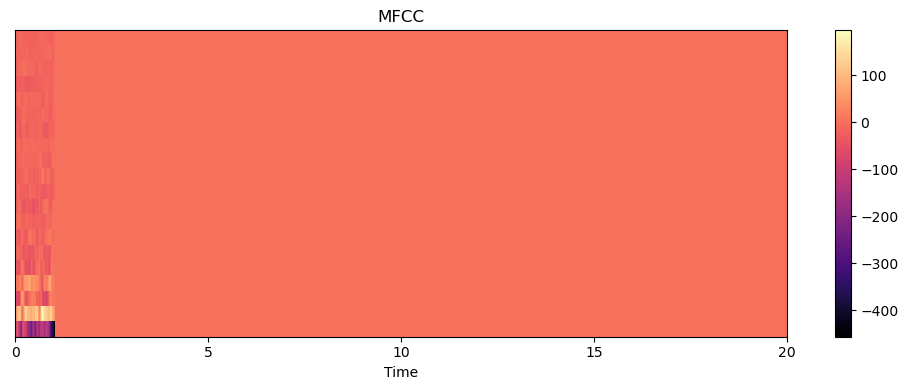

In [3]:
import librosa

# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features_final[0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [4]:
features_final = np.array(features_final)
labels_final = np.array(labels_final)
print(len(features_final))
print(len(labels_final))

In [ ]:
# add channel dimension for CNN
features_final = np.reshape(features_final, (*features_final.shape,1))
#label_list = np.reshape(label_list, (*label_list.shape,1)) 

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features_final, labels_final, stratify=labels_final, test_size=0.2, random_state = 42)

### Instantiate Model vars

In [ ]:
print(features_final.shape)
print(labels_final.shape)

In [ ]:
# ORIGINAL
num_rows = 20
num_columns = 862
num_channels = 1

num_labels = labels_final.shape[1]
print(num_labels)
filter_size = 2

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(num_rows, num_columns, num_channels)))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation='softmax'))

### Fit the model

In [ ]:
# Compile the model
# Train standard
epochs = 70
batch_size = 100
verbose = 1
#optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
)


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(x_test, y_test))


callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]

model.fit(x_train, y_train, batch_size=batch_size,verbose=verbose, epochs=epochs,validation_data=(x_test, y_test), callbacks=callbacks)


In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

### Test model with the Dataset used for the training phase

In [ ]:
from keras.models import load_model
model = load_model('/kaggle/working/mymodel2_59.h5')

In [ ]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 
print(classpreds)
print("----------------------------")
y_testclass = np.argmax(y_test, axis=1) # true classes
print(y_testclass)

n_classes=2 # number of classes

In [ ]:
c_names = ['bonafide', 'fake']

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=c_names))

### Open "Train" for the Evaluation


In [ ]:
with open('./eval_features.npz', 'rb') as f:
    features = np.load(f)
    print(features['a'])

with open('./eval_labels.npz', 'rb') as l:
    labels = np.load(l)
    print(labels['a'])

In [ ]:
sub = pd.read_csv("../input/sample_submission.csv")

for index, row in tqdm(sub.iterrows()):
    wave, sr = librosa.load(TEST + row["fname"], mono=True, sr=None)
    wave = wave[::2]
    
    mfcc = wav2mfcc(wave)
    X_test = mfcc.reshape(1, feature_dim_1, feature_dim_2, channel)
    preds = model.predict(X_test)[0]
    
    for i, col in enumerate(target_labels):
        sub.loc[index, col] = preds[i]